In [1]:
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras
import tensorflow as tf
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if gpus:
    gpu0 = gpus[0] 
    tf.config.experimental.set_memory_growth(gpu0, True) 
    tf.config.set_visible_devices([gpu0],"GPU")

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17144225545577617876
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40231960576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12749245357338270079
physical_device_desc: "device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 12 06:07:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    52W / 400W |    632MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pathlib

data_dir = "/content/drive/MyDrive/Colab Notebooks/28-data/"
#data_dir = r"D:\603_project\28-data"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("# of images: ",image_count)

# of images:  12000


In [7]:
batch_size = 64
img_height = 322  
img_width  = 480
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 12000 files belonging to 15 classes.
Using 9600 files for training.


In [8]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 322, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12000 files belonging to 15 classes.
Using 2400 files for validation.


In [10]:
class_names = train_ds.class_names
print("labels are ",class_names)

labels are  ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']


In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 322, 480, 3)
(64,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
def train_preprocessing(image,label):
    return (image/255.0,label)
train_ds = (
    train_ds.cache().map(train_preprocessing).prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache().map(train_preprocessing).prefetch(buffer_size=AUTOTUNE)
)

In [13]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 322, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

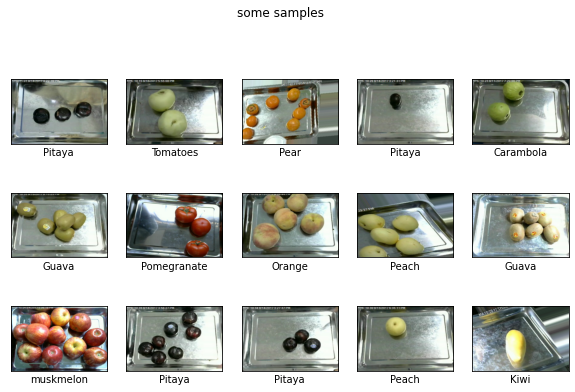

In [14]:
plt.figure(figsize=(10, 8))  
plt.suptitle("some samples")

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]-1])
plt.show()

In [15]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation

base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))

for layer in base_model.layers:
    layer.trainable = True
    
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(class_names), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

17225924/17225924 [==============================] - 0s 0us/step


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 10
PATIENCE  = 5
VERBOSE   = 1


earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)


checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [18]:
train_model  = model.fit(train_ds,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[ earlystopper, checkpointer])

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 1.3626 - accuracy: 0.8231
Epoch 1: val_accuracy improved from -inf to 0.95417, saving model to best_model.h5
150/150 [==============================] - 204s 1s/step - loss: 1.3626 - accuracy: 0.8231 - val_loss: 0.9557 - val_accuracy: 0.9542
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 1.0329 - accuracy: 0.9773
Epoch 2: val_accuracy improved from 0.95417 to 0.98083, saving model to best_model.h5
150/150 [==============================] - 135s 898ms/step - loss: 1.0329 - accuracy: 0.9773 - val_loss: 0.9700 - val_accuracy: 0.9808
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.9946
Epoch 3: val_accuracy improved from 0.98083 to 0.99000, saving model to best_model.h5
150/150 [==============================] - 135s 901ms/step - loss: 0.8959 - accuracy: 0.9946 - val_loss: 0.9011 - val_accuracy: 0.9900
Epoch 4/10
150/150 [==============================] - E

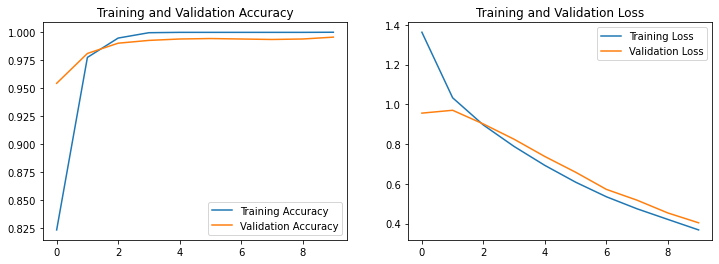

In [19]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_cm(labels, predictions):
    
    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('confusion matrix',fontsize=15)
    plt.ylabel('real value',fontsize=14)
    plt.xlabel('predict value',fontsize=14)

In [21]:
val_pre   = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = tf.expand_dims(image, 0) 
        prediction = model.predict(img_array)
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 [==============================] - 0s 20ms/step


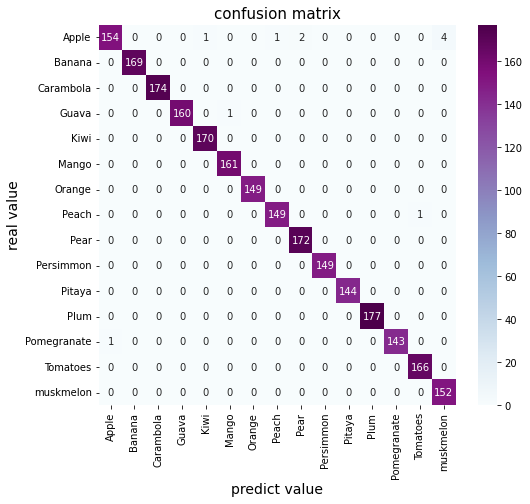

In [22]:
plot_cm(val_label, val_pre)

In [23]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names)) 
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])
    
test_accuracy_report(model)

              precision    recall  f1-score   support

       Apple       0.99      0.95      0.97       162
      Banana       1.00      1.00      1.00       169
   Carambola       1.00      1.00      1.00       174
       Guava       1.00      0.99      1.00       161
        Kiwi       0.99      1.00      1.00       170
       Mango       0.99      1.00      1.00       161
      Orange       1.00      1.00      1.00       149
       Peach       0.99      0.99      0.99       150
        Pear       0.99      1.00      0.99       172
   Persimmon       1.00      1.00      1.00       149
      Pitaya       1.00      1.00      1.00       144
        Plum       1.00      1.00      1.00       177
 Pomegranate       1.00      0.99      1.00       144
    Tomatoes       0.99      1.00      1.00       166
   muskmelon       0.97      1.00      0.99       152

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00   